In [48]:
import math
import torch
import matplotlib.pyplot as plt
import seaborn as sns
from rich import print as rprint
from rich.traceback import install
install()

<bound method InteractiveShell.excepthook of <ipykernel.zmqshell.ZMQInteractiveShell object at 0x7f9ba6030df0>>

In [2]:
%load_ext autoreload
%autoreload 2

In [128]:
embed_dim = 200
num_heads = 8
head_dim = 32
max_length_q= 234
max_length_k= 345
padding_idx = 0
dropout_p = 0.1

batch_size = 3
num_ts = 2
q = torch.randn(batch_size, num_heads, max_length_q, head_dim)
k = torch.randn(batch_size, num_heads, max_length_k, head_dim)

## TUPE

In [7]:
from positional_embeddings_pytorch import UnifiedPositionalEmbedding

In [8]:
pe = UnifiedPositionalEmbedding(
    head_dim=head_dim,
    num_heads=num_heads,
    max_length=max(max_length_q, max_length_k),
    dropout_p=dropout_p,
)
pe.forward_attn(q, k, position_q=None, position_k=None).shape

torch.Size([3, 8, 234, 345])

## TUPE Dount

In [121]:
from positional_embeddings_pytorch import DountUnifiedPositionalEmbedding

In [122]:
# this is from T5
def relative_position_bucket(
    relative_position,
    bidirectional: bool = True,
    num_buckets: int = 32,
    max_distance: int = 128,
):
    ret = 0
    n = -relative_position
    if bidirectional:
        num_buckets //= 2
        ret = (n < 0).long() * num_buckets  # mtf.to_int32(mtf.less(n, 0)) * num_buckets
        n = torch.abs(n)
    else:
        n = torch.max(n, torch.zeros_like(n))
    # now n is in the range [0, inf)

    # half of the buckets are for exact increments in positions
    max_exact = num_buckets // 2
    is_small = n < max_exact

    # The other half of the buckets are for logarithmically bigger bins in positions up to max_distance
    val_if_large = (
        max_exact
        + (
            torch.log(n.float() / max_exact)
            / math.log(max_distance / max_exact)
            * (num_buckets - max_exact)
        ).long()
    )
    val_if_large = torch.min(
        val_if_large, torch.full_like(val_if_large, num_buckets - 1)
    )

    ret += torch.where(is_small, n, val_if_large)
    return ret


tensor(70.) tensor(1897.) tensor(73.) tensor(1897.)

torch.Size([3, 8, 234, 345])

torch.Size([3, 2, 8, 234, 345])

<AxesSubplot:>

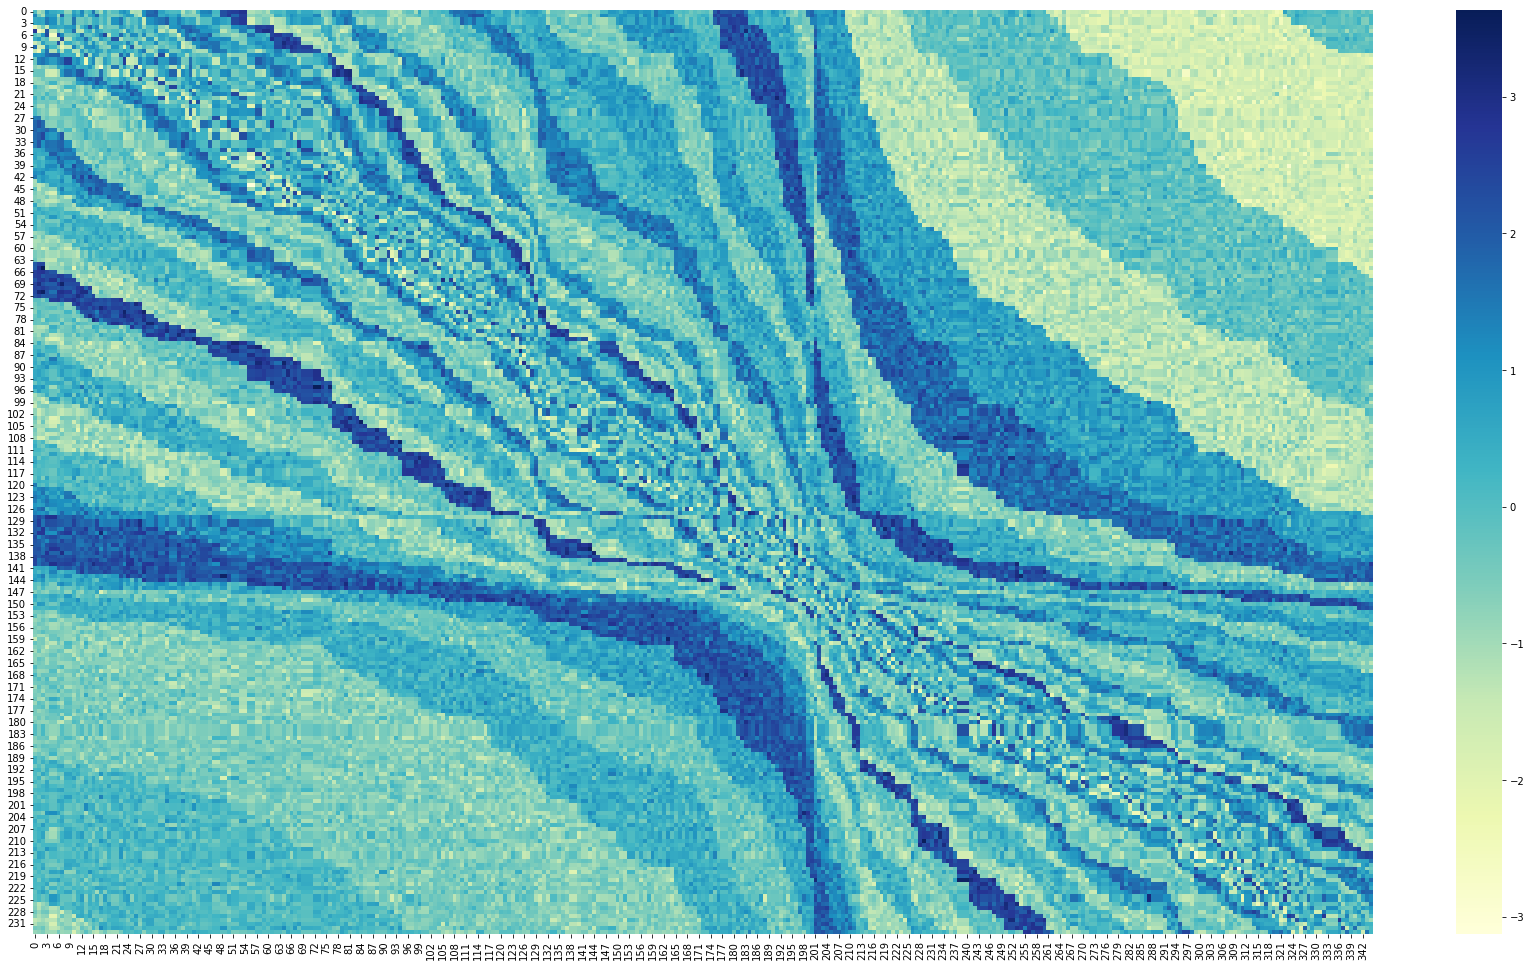

In [125]:
pe = DountUnifiedPositionalEmbedding(
    head_dim=head_dim,
    num_heads=num_heads,
    max_pos=2000,
    dropout_p=0,
    max_distance=2000,
    num_buckets=128
)

tss = torch.rand(batch_size, num_ts) * 2 * 10**6
position_q = (torch.rand(batch_size, max_length_q) * 2 * 10**6).sort()[0]
position_k = (torch.rand(batch_size, max_length_k) * 2 * 10**6).sort()[0]
position_q = position_q[:, None, :] - tss[:, :, None]
position_k = position_k[:, None, :] - tss[:, :, None]
position_q /= 2  # [-1_000_000, 1_000_000]
position_k /= 2
position_q = position_q.abs().sqrt() * position_q.sign() + 10**3  # [0, 2_000]
position_k = position_k.abs().sqrt() * position_k.sign() + 10**3

position_q = position_q.round()
position_k = position_k.round()

rprint(position_q.min(), position_q.max(), position_k.min(), position_k.max())
rprint(pe.forward_attn(q, k, position_q, position_k).shape)
attn_bias = pe.compute_bias(position_q, position_k)
rprint(attn_bias.shape)

fig, axs = plt.subplots(1, 1, figsize=(30, 17))
sns.heatmap(attn_bias.detach().numpy()[0, 0, 0], cmap="YlGnBu", ax=axs)
# sns.heatmap(attn_bias.detach().numpy()[0, 0], cmap="YlGnBu", ax=axs[0])
# sns.heatmap(attn_bias.detach().numpy()[0, 1], cmap="YlGnBu", ax=axs[1])
# sns.heatmap(attn_bias.detach().numpy()[0, 2], cmap="YlGnBu", ax=axs[2])

In [79]:
rel_pos_1 = position_k[0][None, :] - position_q[0][:, None]
rprint(relative_position_bucket(rel_pos_1.long()).shape)

rel_pos_2 = position_k[:, None, :] - position_q[:, :, None]
rprint(relative_position_bucket(rel_pos_2.long()).shape)

torch.isclose(relative_position_bucket(rel_pos_2.long())[0], relative_position_bucket(rel_pos_1.long())).all()

torch.Size([234, 345])

torch.Size([3, 234, 345])

tensor(True)

## Enformer

In [86]:
from positional_embedding import EnformerPositionalEmbedding

In [87]:
pe = EnformerPositionalEmbedding(
    num_heads=num_heads,
    head_dim=head_dim,
    dropout_p=dropout_p,
)

In [88]:
pe.forward_attn(q, k, positions_q=None, positions_k=None).shape

torch.Size([345, 256])


torch.Size([345, 234])

## T5 relative positional embedding

In [89]:
from positional_embedding import UnifiedPositionalEmbedding

torch.Size([1, 64, 128, 128])

<AxesSubplot:>

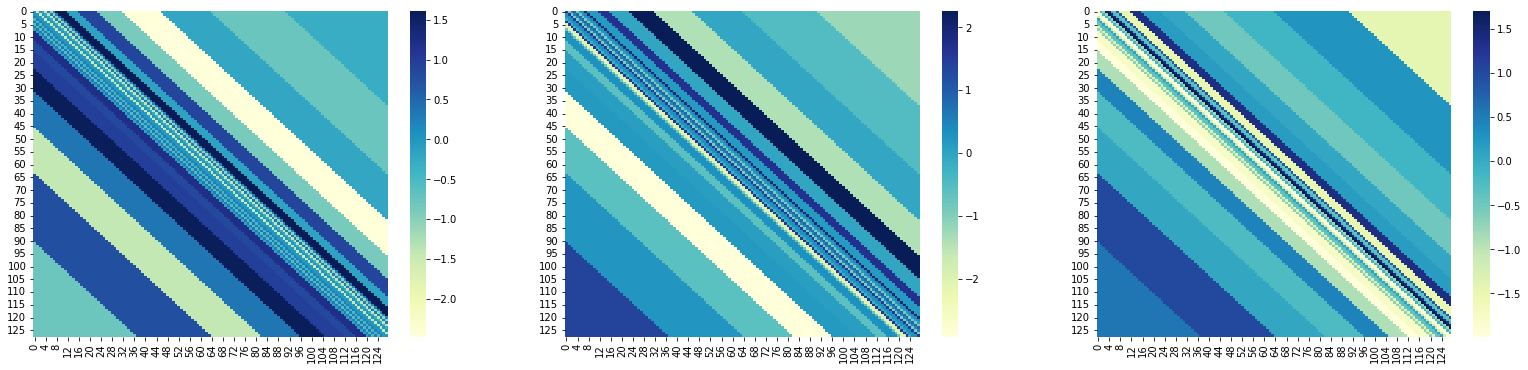

In [2]:
pe = T5PositionalEmbedding(num_buckets=32, n_heads=64)
k_length, q_length = 128, 128
pe_res = pe.compute_bias(k_length, q_length)
rprint(pe_res.shape)
fig, axs = plt.subplots(1, 3, figsize=(27, 6))
sns.heatmap(pe_res.detach().numpy()[0, 0], cmap="YlGnBu", ax=axs[0])
sns.heatmap(pe_res.detach().numpy()[0, 1], cmap="YlGnBu", ax=axs[1])
sns.heatmap(pe_res.detach().numpy()[0, 2], cmap="YlGnBu", ax=axs[2])

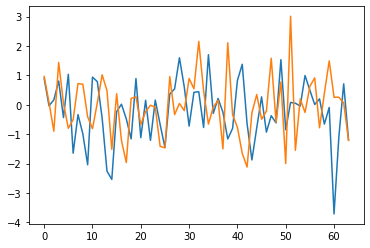

In [3]:
plt.plot(pe_res.detach().numpy()[0, :, 20, 40])
plt.plot(pe_res.detach().numpy()[0, :, 40, 20])

## Transformer XL relative positional embedding

In [3]:
model_dim = 512
num_heads = 8
head_dim = 64
pe = TransformerXLPositionalEmbedding(model_dim=model_dim, num_heads=8, head_dim=64, dropout_p=0.1)
k_length = 128
q = torch.randn(2, num_heads, k_length, head_dim)
k = torch.randn(2, num_heads, k_length, head_dim)
pos_seq = torch.arange(k_length - 1, -1, -1.0)
rprint(pe(pos_seq, q, k).shape)


torch.Size([2, 8, 128, 128])

## Sinusoidal positional embedding

In [7]:
pe = SinusoidalPositionalEmbedding(num_embeddings=1024, embedding_dim=256, padding_idx=0)
input_ = torch.randint(1, 20, (3, 100))
pe_res = pe(input_)
rprint("pe_res shape:", pe_res.shape)

pe_res shape:
torch.Size([3, 100, 256])

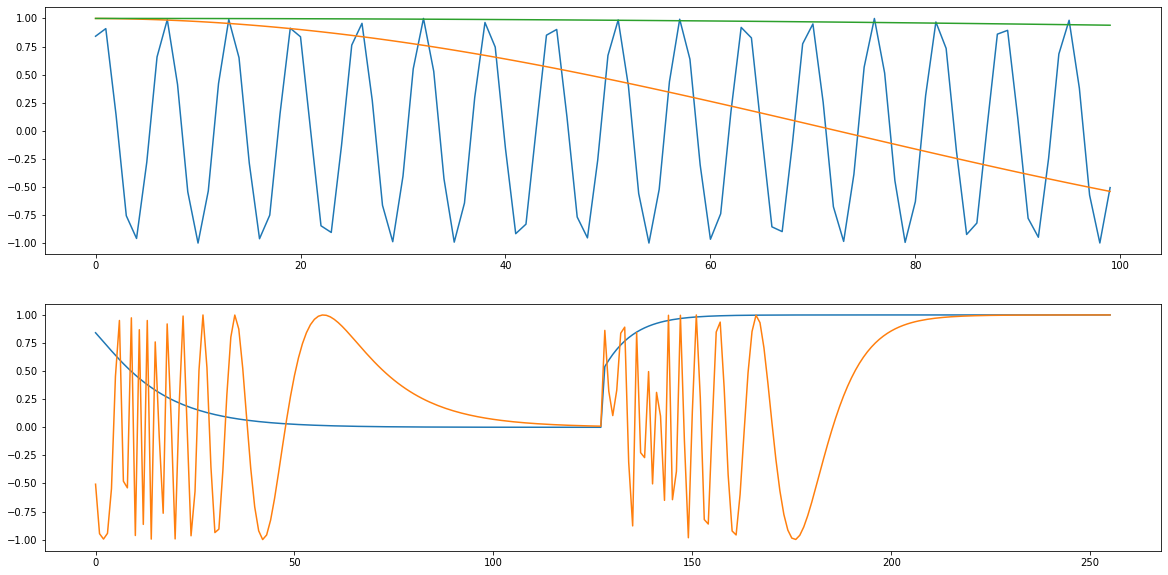

In [8]:
fig, axs = plt.subplots(2, 1, figsize=(20, 10))
axs[0].plot(pe_res.detach().numpy()[0, :, 0])
axs[0].plot(pe_res.detach().numpy()[0, :, -75])
axs[0].plot(pe_res.detach().numpy()[0, :, -50])

axs[1].plot(pe_res.detach().numpy()[0, 0])
axs[1].plot(pe_res.detach().numpy()[0, -1])

<AxesSubplot:>

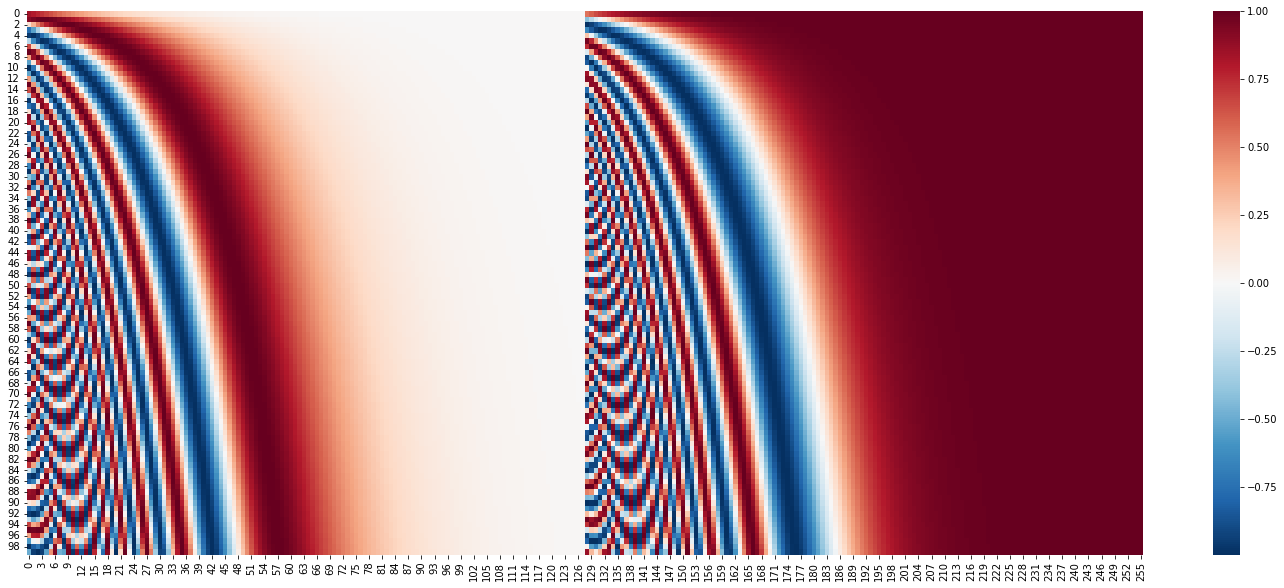

In [9]:
fig, axs = plt.subplots(1, 1, figsize=(25, 10))
sns.heatmap(pe_res.detach().numpy()[0, :, :], cmap="RdBu_r", ax=axs)

## Learned positional embedding

In [5]:
pe = LearnedPositionalEmbedding(num_embeddings = 1024, embedding_dim=16, padding_idx=30)
input_ = input_ = torch.randint(1, 20, (3, 100))
pe_res = pe(input_)
rprint("pe_res shape:", pe_res.shape)

pe_res shape:
torch.Size([3, 64, 16])

## Transformer XL relative positional embedding

In [15]:
q = torch.randn(3,4,5,6)
k = torch.randn(3,4,5,6)
r = torch.randn(1, 4, 1, 6)

d = torch.einsum("bhqd, bhkd -> bhqk", q, k)
e = torch.einsum("bhqd, bhkd -> bhqk", r.expand_as(k), k)
f = torch.einsum("bhqd, bhkd -> bhqk", q + r, k)


In [22]:
torch.isclose(d + e, f).all()

tensor(True)